<a href="https://colab.research.google.com/github/andrea-gasparini/nlp-word-in-context-disambiguation/blob/main/hw1/stud/world-level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word-in-Context (WiC) Disambiguation

First homework of the Natural Language Processing course 2021 @ Sapienza University of Rome.

Prof. Roberto Navigli

MSc in Computer Science

This notebook contains the code for the word level (first approach) solution.

**Author**: Andrea Gasparini - 1813486

# Setup the environment

In [ ]:
# @title Imports

!pip install jsonlines

import jsonlines
import json
import os
import re

from typing import *
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import torch

from torch import Tensor
from torch.utils.data import Dataset, DataLoader

In [ ]:
# @title Init Drive directories

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ROOT_DIR = '/content/drive/My Drive/nlp_data/hw1/'

assert os.path.isdir(ROOT_DIR), f"{ROOT_DIR} is not a valid root directory"

TRAIN_JSONL = os.path.join(ROOT_DIR, "train.jsonl")

assert os.path.isfile(TRAIN_JSONL), f"{TRAIN_JSONL} does not contain a valid train dataset"

DEV_JSONL = os.path.join(ROOT_DIR, "dev.jsonl")

assert os.path.isfile(DEV_JSONL), f"{DEV_JSONL} does not contain a valid development dataset"

GLOVE_DIR = '/content/data/glove/'

Mounted at /content/drive


In [ ]:
# @title Util functions


def str_to_bool(s : str) -> bool:
    return s == 'True'


def visualize_distribution(dataset: str, title: str):
    label_counter = Counter()

    with open(dataset) as f:
        for line in f:
            sample = json.loads(line)
            label = str_to_bool(sample['label'])
            label_counter[label] += 1
    
    values = [label_counter[label] for label in label_counter]
    labels = [str(label) for label in label_counter]

    plt.bar(labels, values)
    plt.title(title)
    plt.show()


def cosine_similarity(v1: torch.Tensor, v2: torch.Tensor) -> float:
    num = torch.sum(v1 * v2)
    den = torch.linalg.norm(v1) * torch.linalg.norm(v2)
    return (num / den).item()


def plot_logs(logs: Dict, title: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(logs['train_history']))), logs['train_history'], label='Train loss')
    if 'valid_history' in logs:
        plt.plot(list(range(len(logs['valid_history']))), logs['valid_history'], label='Validation loss')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="lower left")

    plt.show()

# Plot distributions

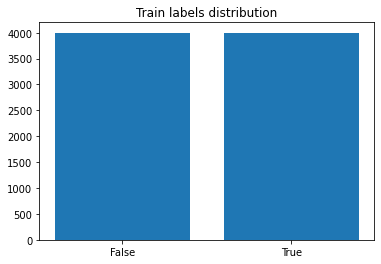

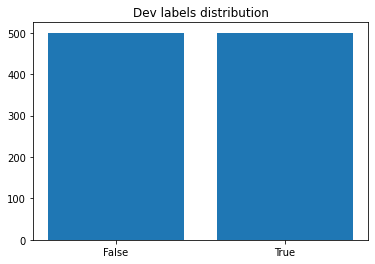

In [ ]:
# @title

visualize_distribution(TRAIN_JSONL, 'Train labels distribution')
visualize_distribution(DEV_JSONL, 'Dev labels distribution')

# Word embeddings

Download pre-trained GloVe word vectors and move them in a data folder

In [ ]:
GLOVE_ARCHIVE = "glove.6B.zip"

# ! mkdir -p {GLOVE_DIR}
# ! wget http://nlp.stanford.edu/data/{GLOVE_ARCHIVE} -P {GLOVE_DIR}
# ! unzip {GLOVE_DIR}{GLOVE_ARCHIVE} -d {GLOVE_DIR}
# ! rm {GLOVE_DIR}{GLOVE_ARCHIVE}

## Init the word vectors dictionary

In [ ]:
class WordEmbeddings:
    embeddings_dir = ROOT_DIR
    unknown_embedding_files = {
        200: "unknown.200d.txt"
    }
    glove_dir = GLOVE_DIR
    embedding_files = {
        50: "glove.6B.50d.txt",
        100: "glove.6B.100d.txt",
        200: "glove.6B.200d.txt",
        300: "glove.6B.300d.txt"
    }

    def __init__(self, words_limit: int = 100_000, embedding_size: int = 200):
        assert embedding_size in self.embedding_files, f"Unsupported embedding size: {embedding_size}"

        self.words_limit = words_limit
        self.embedding_size = embedding_size

        self._init_unknown_embedding()
        #self.UNK = torch.rand(embedding_size)
        self.word_vectors = defaultdict(lambda: self.UNK)

        self._init_data()

    def _init_unknown_embedding(self):
        assert self.embedding_size in self.unknown_embedding_files, f"Unsupported embedding size: {self.embedding_size}"

        filename = self.unknown_embedding_files[self.embedding_size]
        file_path = os.path.join(self.embeddings_dir, filename)
        assert os.path.isfile(file_path), f"unknown word embedding {filename} not found in {self.embeddings_dir}"

        with open(file_path) as f:
            vector = f.readline().strip().split(' ')
            self.UNK = torch.tensor([float(c) for c in vector])

    def _init_data(self):
        filename = self.embedding_files[self.embedding_size]
        file_path = os.path.join(self.glove_dir, filename)

        if not os.path.isfile(file_path):
            file_path = os.path.join(ROOT_DIR, filename)            
            assert os.path.isfile(file_path), f"GloVe embedding {filename} not found in {self.glove_dir} or {ROOT_DIR}"        
            print(f"Loaded from {ROOT_DIR}")
        else:
            print(f"Loaded from {self.glove_dir}")

        with open(file_path) as f:
            for i, line in enumerate(f):

                if len(self.word_vectors) >= self.words_limit:
                    break

                word, *vector = line.strip().split(' ')
                vector = torch.tensor([float(c) for c in vector])

                self.word_vectors[word] = vector

    def __contains__(self, word: str) -> bool:
        return word in self.word_vectors

    def __getitem__(self, word: str) -> torch.Tensor:
        return self.word_vectors[word]

In [ ]:
word_vectors = WordEmbeddings(embedding_size=200)

Loaded from /content/drive/My Drive/nlp_data/hw1/


## Sample to vector function

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

def substitute_spacing_characters(string: str) -> str:
    return re.sub(r'[\-—_/]', ' ', string)


def remove_special_characters(string: str) -> str:
    return re.sub(r'[\.,:;|!?@#$"“”\'’\(\)\[\]&\\<>0-9]', '', string)


def sentence2vector(word_vectors: WordEmbeddings, sentence: str, target_start: int, target_weight: int) -> List[torch.Tensor]:
    sentence = substitute_spacing_characters(sentence).lower()
    target_word_index = sentence[:target_start].count(' ')

    sentence_word_vector = list()

    for i, word in enumerate(sentence.split(' ')):
        if True or word not in stopwords:
            word = remove_special_characters(word)
            word_vector = word_vectors[word]
            if i == target_word_index:
                word_vector * target_weight
            sentence_word_vector.append(word_vector)

    return sentence_word_vector
    

def sample2vector(word_vectors: WordEmbeddings, sample: dict, separator: str = '|', target_weight: int = 10) -> torch.Tensor:
    sentence1 = sentence2vector(word_vectors, sample['sentence1'], int(sample['start1']), int(sample['end1']), target_weight)
    sentence2 = sentence2vector(word_vectors, sample['sentence2'], int(sample['start2']), int(sample['end2']), target_weight)

    sentence1mean = torch.mean(torch.stack(sentence1), dim=0)
    sentence2mean = torch.mean(torch.stack(sentence2), dim=0)
    
    sentences_word_vector = torch.cat((sentence1mean, sentence2mean))
    
    return sentences_word_vector

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Model creation

## Dataset class

In [ ]:
class WiCDisambiguationDataset(Dataset):
    target_word_weight = 10

    def __init__(self, samples: List[Dict], word_embeddings: WordEmbeddings, stop_words: Optional[Set[str]] = None) -> None:
        self.samples = samples
        self.word_embeddings = word_embeddings
        self.stop_words = stop_words

        self.encoded_samples, self.encoded_labels = self.encode_samples(self.samples)

    @staticmethod
    def from_file(path: str, word_embeddings: WordEmbeddings, stop_words: Optional[Set[str]] = None) -> 'WiCDisambiguationDataset':
        samples = list()

        with jsonlines.open(path) as f:
            for sample in f:
                samples.append(sample)

        return WiCDisambiguationDataset(samples, word_embeddings, stop_words)

    def encode_samples(self, samples: List[Dict]) -> Tuple[List[Tensor], List[Optional[Tensor]]]:
        encoded_samples = list()
        encoded_labels = list()

        for sample in samples:
            sentence1_vector = self.__sentence_to_vector(sample['sentence1'], int(sample['start1']))
            sentence2_vector = self.__sentence_to_vector(sample['sentence2'], int(sample['start2']))

            sentence1_mean = torch.mean(sentence1_vector, dim=0)
            sentence2_mean = torch.mean(sentence2_vector, dim=0)        

            encoded_samples.append(torch.cat((sentence1_mean, sentence2_mean)))

            if 'label' in sample:
                encoded_label = torch.tensor(float(1 if str_to_bool(sample['label']) else 0))
                encoded_labels.append(encoded_label)
            else:
                encoded_labels.append(None)

        return encoded_samples, encoded_labels

    def __sentence_to_vector(self, sentence: str, target_start: int) -> Tensor:
        sentence = substitute_spacing_characters(sentence).lower()
        target_word_index = sentence[:target_start].count(' ')

        sentence_word_vector = list()

        for i, word in enumerate(sentence.split(' ')):
            if self.stop_words is None or word not in self.stop_words:
                word = remove_special_characters(word)
                word_vector = self.word_embeddings[word]
                if i == target_word_index:
                    word_vector * self.target_word_weight
                sentence_word_vector.append(word_vector)

        return torch.stack(sentence_word_vector)

    def __len__(self) -> int:
        return len(self.encoded_samples)

    def __getitem__(self, idx) -> Tuple[List[Tensor], List[Optional[Tensor]]]:
        return self.encoded_samples[idx], self.encoded_labels[idx]

## Classifier class

In [ ]:
class WiCDisambiguationClassifier(torch.nn.Module):

    def __init__(self, n_features: int, n_hidden: int):
        super().__init__()
        self.lin1 = torch.nn.Linear(n_features, n_hidden)
        self.lin2 = torch.nn.Linear(n_hidden, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.loss_fn = torch.nn.BCELoss()

    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        out = self.lin1(x)
        #out = self.dropout(out)
        out = torch.relu(out)
        logits = self.lin2(out).squeeze(1)
        pred = torch.sigmoid(logits)

        result = {'pred': pred, 'logits': logits}

        if y is not None:
            loss = self.loss(pred, y)
            result['loss'] = loss

        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

# Training

In [ ]:
class Trainer:

    def __init__(self, model: torch.nn.Module, optimizer: torch.optim.Optimizer) -> None:
        self.model = model
        self.optimizer = optimizer
        self.train_history = list()
        self.valid_history = list()
        self.global_epoch = 0

    def train(self, train_dataloader: DataLoader, dev_dataloader: DataLoader = None, epochs: int = 5,
              early_stopping: bool = False, early_stopping_patience: int = 0) -> dict:

        early_stopping_patience_counter = 0

        for epoch in range(epochs):
            losses = []
            self.global_epoch = epoch
            self.model.train()

            for x, y in train_dataloader:
                self.optimizer.zero_grad()
                result = self.model(x, y)
                loss = result['loss']
                losses.append(loss)

                loss.backward()
                self.optimizer.step()

            mean_loss = sum(losses) / len(losses)
            self.train_history.append(mean_loss.item())
                    
            if dev_dataloader:
                validation_loss = self.evaluate(dev_dataloader)
                self.valid_history.append(validation_loss.item())

                if early_stopping and epoch > 0 and self.valid_history[-1] > self.valid_history[-2]:
                    if early_stopping_patience_counter < early_stopping_patience:
                        early_stopping_patience_counter += 1
                    else:
                        break
        return {
            'train_history': self.train_history,
            'valid_history': self.valid_history,
        }

    def evaluate(self, validation_dataloader: DataLoader):
        losses = []
        self.model.eval()

        with torch.no_grad():
            for x, y in validation_dataloader:
                result = self.model(x, y)
                loss = result['loss']
                losses.append(loss)

        return sum(losses) / len(losses)

    def plot_losses(self):

        plt.figure(figsize=(8, 6))

        plt.plot(list(range(len(self.train_history))), self.train_history, label='Training loss')
        if len(self.valid_history) > 0:
            plt.plot(list(range(len(self.valid_history))), self.valid_history, label='Validation loss')
            plt.title('Training vs Validation loss')
        else:
            plt.title('Training loss')

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc="upper right")

        plt.show()


## Actual training

Final training loss     => 0.31463977694511414
Final validation loss   => 0.7088106870651245


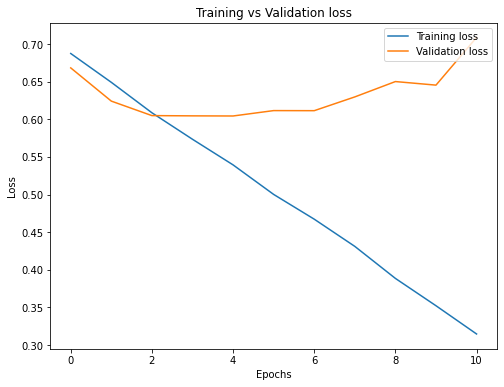

In [ ]:
TRAIN_DATASET = WiCDisambiguationDataset.from_file(f"{ROOT_DIR}train.jsonl", word_vectors, stopwords)
DEV_DATASET = WiCDisambiguationDataset.from_file(f"{ROOT_DIR}dev.jsonl", word_vectors, stopwords)

n_features = word_vectors.embedding_size * 2
hidden_size = n_features // 2
lr = 0.001

model = WiCDisambiguationClassifier(n_features, hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, optimizer)

logs = trainer.train(DataLoader(TRAIN_DATASET, batch_size=32, shuffle=True),
    dev_dataloader=DataLoader(DEV_DATASET, batch_size=32),
    epochs=100, early_stopping=True, early_stopping_patience=3)

print(f"Final training loss     => {logs['train_history'][-1]}")
print(f"Final validation loss   => {logs['valid_history'][-1]}")
trainer.plot_losses()

# Final training loss     => 0.6520485877990723
# Final validation loss   => 0.6707377433776855

# Prediction

In [ ]:
# @title Util functions

def predict(sample: Union[dict, torch.Tensor], model: torch.nn.Module, extraction_fn: Callable[[dict], torch.Tensor]):
    
    if isinstance(sample, dict): sample = extraction_fn(word_vectors, sample)

    # our nn expects a batched input
    # even if we have a single sample, we have to mock this structure converting a (11)-shape vector into (1, 11)-shape one
    batched_sample = sample.unsqueeze(0)

    # actual forward
    result = model(batched_sample)

    return result['pred'][0].item()

def predict_list(samples: List[dict]):
    
    vector_samples = [sample2vector(word_vectors, sample) for sample in samples]

    # actual forward
    result = model(torch.stack(vector_samples))

    return [result['pred'][i].item() for i in range(len(samples))]

def predict_and_print_raw_sample(sample: dict):
    print(f'=' * 125)
    print(f'# sample: {sample}')
    print(f'# gold class: {str_to_bool(sample["label"])}')
    prediction = predict(sample, model, sample2vector2)
    print(f'# predicted class: {prediction} -> {True if round(prediction) > 0.5 else False}')
    print(f'=' * 125)

## Evaluation

In [ ]:
# Load pre-trained model
# path = f'{ROOT_DIR}model-first_approach-02052021_103330-lr=0.001-n_features=400-hidden_size=200-acc=0.6770-f1=0.6770.pt'
# model = WiCDisambiguationClassifier(n_features, hidden_size)
# model.load_state_dict(torch.load(path, map_location='cpu'))
# model.to('cpu')

model.eval()

TEST_DATASET = WiCDisambiguationDataset.from_file(f"{ROOT_DIR}dev.jsonl", word_vectors, stopwords)

labels = TEST_DATASET.encoded_labels
predictions = list()

for i, (sample, label) in enumerate(TEST_DATASET):
    prediction = predict(sample, model, sample2vector)
    predictions.append(torch.tensor(float(round(prediction))))

p = precision_score(labels, predictions, average='macro')
r = recall_score(labels, predictions, average='macro')
f = f1_score(labels, predictions, average='macro')
a = accuracy_score(labels, predictions)

print(f'# precision: {p:.4f}')
print(f'# recall: {r:.4f}')
print(f'# f1: {f:.4f}')
print(f'# acc: {a:.4f}')

# precision: 0.6771
# recall: 0.6770
# f1: 0.6770
# acc: 0.6770


### Confusion matrix

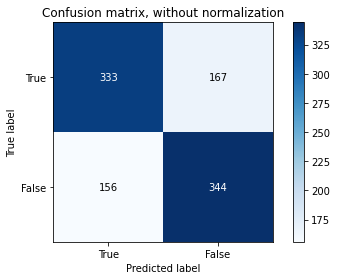

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if not title:
        if normalize: title = 'Normalized confusion matrix'
        else: title = 'Confusion matrix, without normalization'

    classes = np.array([True, False])

    cm = confusion_matrix(y_true, y_pred, labels=classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes) - 0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.25
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()

    return plt, ax

_, _ = plot_confusion_matrix(labels, predictions, normalize=False, cmap=plt.cm.Blues)

### Save model state

In [ ]:
from datetime import datetime

dt_string = datetime.now().strftime("%d%m%Y_%H%M%S")

torch.save(model.state_dict(), f"{ROOT_DIR}model-first_approach-{dt_string}-lr={lr}-n_features={n_features}-hidden_size={hidden_size}-acc={a:.4f}-f1={f:.4f}.pt")

# Hyperparameters tuning

## Optimizer

In [ ]:
TRAIN_DATASET = WiCDisambiguationDataset.from_file(TRAIN_JSONL, word_vectors, sample2vector)
DEV_DATASET = WiCDisambiguationDataset.from_file(f"{ROOT_DIR}dev.jsonl", word_vectors, sample2vector)
labels = DEV_DATASET.encoded_labels

stats = list()

for lr in torch.arange(0.0001, 0.01, 0.0001):
    model = WiCDisambiguationClassifier(word_vectors.embedding_size, 100)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    trainer = Trainer(model, optimizer)

    logs = trainer.train(DataLoader(TRAIN_DATASET, batch_size=32),
        dev_dataloader=DataLoader(DEV_DATASET, batch_size=32),
        epochs=100, early_stopping=True, early_stopping_patience=3)
            
    predictions = list()

    for sample, label in DEV_DATASET:
        prediction = predict(sample, model, sample2vector)
        predictions.append(torch.tensor(float(round(prediction))))

    p = precision_score(labels, predictions, average='macro')
    r = recall_score(labels, predictions, average='macro')
    f = f1_score(labels, predictions, average='macro')
    a = accuracy_score(labels, predictions)

    logs['lr'] = lr
    #logs['momentum'] = momentum
    logs['precision'] = p
    logs['recall'] = r
    logs['f1-score'] = f
    logs['accuracy'] = a
    logs['validation_loss'] = logs['valid_history'][-1]
    logs['final_epoch'] = trainer.global_epoch

    print(f"Learning rate   : {lr:.4f}")
    #print(f"Momentum        : {momentum:.4f}")
    print(f"Final epoch     : {trainer.global_epoch}")
    print(f"Final training loss     => {logs['train_history'][-1]}")
    print(f"Final validation loss   => {logs['valid_history'][-1]}")
    print(f'Precision               => {p:.4f}')
    print(f'Recall                  => {r:.4f}')
    print(f'F1                      => {f:.4f}')
    print(f'Accuracy                => {a:.4f}')
    print()
    
    stats.append(logs)

print(stats)

In [ ]:
from functools import reduce

for title in ["accuracy", "f1-score"]:
    test = reduce(lambda a, b : a if a[title] > b[title] else b, stats)
    print(f"Best {title}: {test[title]}, obtained at epoch {test['final_epoch']} with parameters:")
    print(f"    Learning Rate   => {test['lr']:.4f}")
    #print(f"    Momentum        => {test['momentum']:.4f}")
    print()
    print(f"    F1-score        => {test['f1-score']:.4f}")
    print(f"    Recall          => {test['recall']:.4f}")
    print(f"    Precision       => {test['precision']:.4f}")
    print(f"    Accuracy        => {test['accuracy']:.4f}")
    print("=" * 70)